In [1]:
import math
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
import scipy
# import seaborn as sns
from joblib import Parallel, delayed
from scipy.integrate import nquad, quad, simps
from scipy.stats import entropy, gamma, multivariate_normal, norm
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import normalize
# from sktree.datasets import make_trunk_classification
from sktree.ensemble import HonestForestClassifier
from sktree.stats import build_hyppo_oob_forest
from sktree.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve



In [70]:
SIMULATIONS = {
    "1" : {"m_factor" : -1,'cov_par': 1}, ###"mu = 1.5*1/sqrt(i)"
    "2" : {"m_factor" : 1},
    "3" : {"m_factor" : -1,"mix" : 0.5}
}

SAMP_SIZES = [2**i for i in range(7, 11)]
SAMP_SIZES_plot = [2*2**i for i in range(7, 11)]
REPS = range(100, 1000)
P = 2048
SAVE_PATH  = '/Users/baiyuxin/Desktop/JHU/NDD/Cancer/paper_trunk'

In [3]:
n_jobs = -3
n_estimators = 2000

In [4]:
def sensitivity_at_specificity(y_true, y_score, target_specificity=0.98, pos_label=1):
    n_trees, n_samples, n_classes = y_score.shape

    # Compute nan-averaged y_score along the trees axis
    y_score_avg = np.nanmean(y_score, axis=0)

    # Extract true labels and nan-averaged predicted scores for the positive class
    y_true = y_true.ravel()
    y_score_binary = y_score_avg[:, 1]

    # Identify rows with NaN values in y_score_binary
    nan_rows = np.isnan(y_score_binary)

    # Remove NaN rows from y_score_binary and y_true
    y_score_binary = y_score_binary[~nan_rows]
    y_true = y_true[~nan_rows]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_score_binary, pos_label=pos_label)

    # Find the threshold corresponding to the target specificity
    index = max(np.argmax(fpr > (1 - target_specificity))-1, 0)
    threshold_at_specificity = thresholds[index]

    # Compute sensitivity at the chosen specificity
    # sensitivity = tpr[index]
    # return sensitivity

    # Use the threshold to classify predictions
    y_pred_at_specificity = (y_score_binary >= threshold_at_specificity).astype(int)

    # Compute sensitivity at the chosen specificity
    sensitivity = np.sum((y_pred_at_specificity == 1) & (y_true == 1)) / np.sum(
        y_true == 1
    )

    return sensitivity

In [5]:
SAMP_SIZES = [2**i for i in range(7, 11)]
Reps = 50

In [71]:
import numpy as np
from scipy.stats import multivariate_normal, entropy
from scipy.integrate import nquad

def make_trunk_classification(
    n_samples,
    n_dim=10,
    n_informative=10,
    m_factor: int = -1,
    cov_par: int = 1,
    rho: int = 0,
    band_type: str = "ma",
    return_params: bool = False,
    mix: int = 0,
    seed=None,

):
    """Generate trunk dataset.

    For each dimension in the first distribution, there is a mean of :math:`1 / d`, where
    ``d`` is the dimensionality. The covariance is the identity matrix.
    The second distribution has a mean vector that is the negative of the first.
    As ``d`` increases, the two distributions become closer and closer.

    See full details in :footcite:`trunk1982`.

    Instead of the identity covariance matrix, one can implement a banded covariance matrix
    that follows :footcite:`Bickel_2008`.

    Parameters
    ----------
    n_samples : int
        Number of sample to generate.
    n_dim : int, optional
        The dimensionality of the dataset and the number of
        unique labels, by default 10.
    n_informative : int, optional
        The informative dimensions. All others for ``n_dim - n_informative``
        are uniform noise.
    m_factor : int, optional
        The multiplicative factor to apply to the mean-vector of the first
        distribution to obtain the mean-vector of the second distribution.
        By default -1.
    rho : float, optional
        The covariance value of the bands. By default 0 indicating, an identity matrix is used.
    band_type : str
        The band type to use. For details, see Example 1 and 2 in :footcite:`Bickel_2008`.
        Either 'ma', or 'ar'.
    return_params : bool, optional
        Whether or not to return the distribution parameters of the classes normal distributions.
    mix : float, optional
        Whether or not to mix the Gaussians. Should be a value between 0 and 1.
    seed : int, optional
        Random seed, by default None.

    Returns
    -------
    X : np.ndarray of shape (n_samples, n_dim), dtype=np.float64
        Trunk dataset as a dense array.
    y : np.ndarray of shape (n_samples,), dtype=np.intp
        Labels of the dataset.
    means : list of ArrayLike of shape (n_dim,), dtype=np.float64
        The mean vector for each class starting with class 0.
        Returned if ``return_params`` is True.
    covs : list of ArrayLike of shape (n_dim, n_dim), dtype=np.float64
        The covariance for each class. Returned if ``return_params`` is True.

    References
    ----------
    .. footbibliography::
    """
    if n_dim < n_informative:
        raise ValueError(
            f"Number of informative dimensions {n_informative} must be less than number "
            f"of dimensions, {n_dim}"
        )
    rng = np.random.default_rng(seed=seed)

    mu_1 = np.array([1.2/ np.sqrt(i) for i in range(1, n_informative + 1)])
    mu_0 = m_factor * mu_1

    if rho != 0:
        if band_type == "ma":
            cov = _moving_avg_cov(n_informative, rho)
        elif band_type == "ar":
            cov = _autoregressive_cov(n_informative, rho)
        else:
            raise ValueError(f'Band type {band_type} must be one of "ma", or "ar".')
    else:
        cov = cov_par*np.identity(n_informative)

    if mix < 0 or mix > 1:
        raise ValueError("Mix must be between 0 and 1.")

    if n_informative > 1000:
        method = "cholesky"
    else:
        method = "svd"

    if mix == 0:
        X = np.vstack(
            (
                rng.multivariate_normal(mu_0, cov, n_samples // 2, method=method),
                rng.multivariate_normal(mu_1, cov, n_samples // 2, method=method),
            )
        )
    else:
        mixture_idx = rng.choice(
            [0, 1], n_samples // 2, replace=True, shuffle=True, p=[mix, 1 - mix]
        )
        X_mixture = np.zeros((n_samples // 2, len(mu_1)))
        for idx in range(n_samples // 2):
            if mixture_idx[idx] == 1:
                X_sample = rng.multivariate_normal(mu_1, cov, 1, method=method)
            else:
                X_sample = rng.multivariate_normal(mu_0, cov, 1, method=method)
            X_mixture[idx, :] = X_sample

        X = np.vstack(
            (
                rng.multivariate_normal(
                    np.zeros(n_informative), cov, n_samples // 2, method=method
                ),
                X_mixture,
            )
        )

    if n_dim > n_informative:
        # X = np.hstack((X, rng.uniform(low=0, high=1, size=(n_samples, n_dim - n_informative))))
        X = np.hstack((X, rng.multivariate_normal(np.zeros(n_dim - n_informative), cov_par*np.identity(n_dim - n_informative), n_samples, method=method)))

    y = np.concatenate((np.zeros(n_samples // 2), np.ones(n_samples // 2)))

    if return_params:
        return X, y, [mu_0, mu_1], [cov, cov]
    return X, y


In [62]:
n = 1000000

DIMENSIONS = [2**i for i in range(2,9)]
# DIMENSIONS = [i for i in range(2, 100,2)]
for i in ["1"]:
    print(int(i))
    MIs = []
    pAUCs = []
    tprs = []
    for p in [1]:
        print("Dimension" + str(p))
        ### sample from TRUNK
        x,y,mu,cov = make_trunk_classification(n_samples=n, n_dim=p,n_informative=p, **SIMULATIONS[i],return_params = True)
        p_class0 = 0.5
        p_class1 = 0.5
        x = np.float32(x)
        y = np.float32(y)
        ## Get the pdf for class one and class two
        pdf_class0 = multivariate_normal(mean = mu[0], cov = cov[0],allow_singular=True)
        pdf_class1 = multivariate_normal(mean = mu[1], cov = cov[1],allow_singular=True)
        print(mu[1][0],cov[0][0])
        
        p_x_given_class0 = np.nan_to_num(np.float128(pdf_class0.pdf(x)))
        p_x_given_class1 = np.nan_to_num(np.float128(pdf_class1.pdf(x)))


        p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1
        # pos_class0 = p_x_given_class0*p_class0/p_x

        pos_class0 = (np.array([p_x_given_class0[i]*p_class0/p_x[i] if p_x[i] != 0 else 0 for i in range(p_x.shape[0])]).reshape(-1,1))
        pos_class1 = np.ones(pos_class0.shape) - pos_class0

        posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
        print(posterior)
        # posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
        # stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
        prior_y = np.array([p_class0,p_class1])
        # entropy_y = entropy(prior_y, base=np.exp(1))
        # print('entropy'+str(stats_conen))
        # MI = entropy_y - stats_conen
        # print("MI"+str(MI))
        # MIs.append(MI)
        # # plt.scatter(x[:,0],x[:,-1],c = y,alpha = 0.3,s=2)
        # # plt.show()
        pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
        print('pAUC '+ str(pauc))
        pAUCs.append(pauc)

        fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
        tpr_s = np.max(tpr[fpr<=0.02])
        print('S@98 '+ str(tpr_s))


1
Dimension1
1.0 [0.5]
[[0.90888025 0.09111975]
 [0.99319888 0.00680112]
 [0.8414429  0.1585571 ]
 ...
 [0.00253796 0.99746204]
 [0.02767178 0.97232822]
 [0.23907992 0.76092008]]
pAUC 0.9158151410105263
S@98 0.781038


In [63]:
#### Mixture Gaussian
n = 300000
MIs = []
pAUCs = []
tprs = []
p_class0 = 0.5
p_class1 = 0.5
for p in [1]:
    mu_class0 = np.array([0 for i in range(p)])
    mu_class1 = np.array([3.5*1/np.sqrt(i+1) for i in range(p)])
    sig = np.identity(p)
    pdf_class0 = multivariate_normal(mean = mu_class0, cov = sig,allow_singular=True)
    pdf_class1_1 = multivariate_normal(mean = mu_class1, cov = sig,allow_singular=True)
    pdf_class1_2 = multivariate_normal(mean = -mu_class1, cov = sig,allow_singular=True)

    n1 = np.random.binomial(n, 0.5)
    n2 = n - n1
    # print(n1,n2)
    x_0 = pdf_class0.rvs(size = n)
    x_1_1 = pdf_class1_1.rvs(size = n1)
    x_1_2 = pdf_class1_2.rvs(size = n2)
    print(x_0.shape,x_1_1.shape,x_1_2.shape)
    x = np.vstack((x_0.reshape(-1,1),x_1_1.reshape(-1,1),x_1_2.reshape(-1,1)))
    y = np.array([0]*n+[1]*n).reshape(-1,1)

    p_x_given_class0 = np.nan_to_num(pdf_class0.pdf(x))
    p_x_given_class1_1 = np.nan_to_num(pdf_class1_1.pdf(x))
    p_x_given_class1_2 = np.nan_to_num(pdf_class1_2.pdf(x))
    p_x_given_class1 = 0.5*p_x_given_class1_1+0.5*p_x_given_class1_2

    p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1

    pos_class0 = np.array([p_x_given_class0[i]*p_class0/p_x[i] if p_x[i] != 0 else 0 for i in range(p_x.shape[0])]).reshape(-1,1)
    pos_class1 = np.ones(pos_class0.shape) - pos_class0

    posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
    # print(posterior.shape)
    # posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0,p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # print('entropy'+str(stats_conen))
    MI = entropy_y - stats_conen
    print("MI"+str(MI))
    MIs.append(MI)
    # plt.scatter(x[:,0],x[:,-1],c = y,alpha = 0.3,s=2)
    # plt.show()
    pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
    print('pAUC '+ str(pauc))
    pAUCs.append(pauc)

    fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
    tpr_s = np.max(tpr[fpr<=0.02])
    print('S@98 '+ str(tpr_s))
    tprs.append(tpr_s)
# np.savetxt("/Users/baiyuxin/Desktop/JHU/NDD/Cancer/Truth_Calculation/Mixture_Gaussian.csv", tprs, delimiter=",")




(300000,) (150337,) (149663,)
MI0.5489146602809801
pAUC 0.9521535728654971
S@98 0.8778666666666667


In [72]:
for i in range(2):
    S98 = []
    for n in SAMP_SIZES:
        est = HonestForestClassifier(
        n_estimators=2000,
        max_samples=1.6,
        max_features=0.3,
        bootstrap= True,
        random_state= 10000*i+n,
        tree_estimator=DecisionTreeClassifier(),
        # max_depth = 1,
        honest_fraction=0.5,
        stratify=True,
        # permute_per_tree=True,
        n_jobs=n_jobs,)

        x,y,mu,cov = make_trunk_classification(n_samples=n, n_dim=2048, **SIMULATIONS["1"],n_informative=1,return_params = True)
        print(mu[1][0],cov[0][0])
        x = np.float32(x)
        y = np.float32(y)
        est,prob = build_hyppo_oob_forest(est,x, y)
        sas98 = sensitivity_at_specificity(y, prob, target_specificity=0.98)
        print(i,n,sas98)
        S98.append(sas98)
    np.savetxt(SAVE_PATH + "/Trunk_1_dim2048_1.2mean1var1info_reps{}.csv".format(i), S98, delimiter=",")

    # S98_array[i,:] = S98


1.2 [1.]
0 128 0.0625
1.2 [1.]
0 256 0.6015625
1.2 [1.]
0 512 0.28125
1.2 [1.]


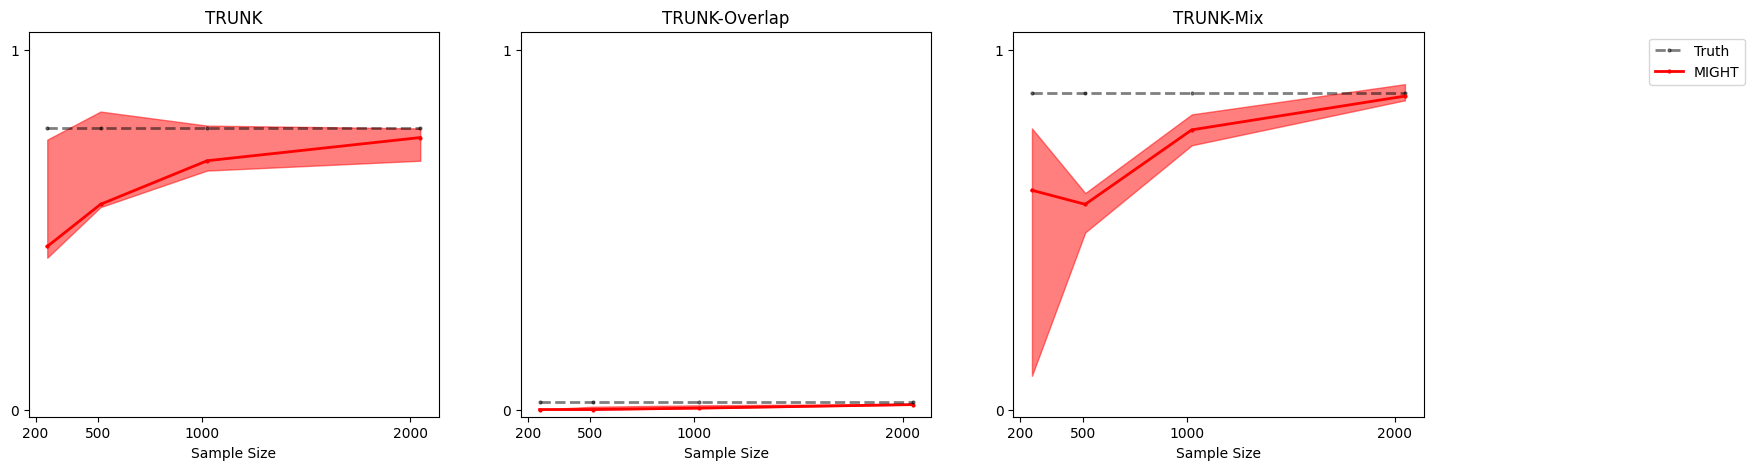

In [66]:
REPs = 5
STATS_S98_TRUNK = np.zeros((REPs,len(SAMP_SIZES)))
STATS_S98_TRUNKOVERLAP = np.zeros((REPs,len(SAMP_SIZES)))
STATS_S98_TRUNKMIX = np.zeros((REPs,len(SAMP_SIZES)))
for k in range(REPs):
    for p in SAMP_SIZES:
        s98 = np.genfromtxt(SAVE_PATH + "/Trunk_1_dim2048_1mean0.5var1info_reps{}.csv".format(k),delimiter=',')
        s98_over = np.genfromtxt(SAVE_PATH + "/Trunk_overlap_reps{}.csv".format(k),delimiter=',')
        s98_mix = np.genfromtxt(SAVE_PATH + "/Trunk_3_dim2048_3.5mean1var1info_reps{}.csv".format(k),delimiter=',')
    STATS_S98_TRUNK[k,:] = s98
    STATS_S98_TRUNKOVERLAP[k,:] = s98_over
    STATS_S98_TRUNKMIX[k,:] = s98_mix

median_MIGHT_TRUNK = np.quantile(STATS_S98_TRUNK, 0.5, axis=0)
mean_MIGHT_TRUNK = np.mean(STATS_S98_TRUNK,axis = 0)
q25_MIGHT_TRUNK = np.quantile(STATS_S98_TRUNK, 0.25, axis=0)
q75_MIGHT_TRUNK = np.quantile(STATS_S98_TRUNK, 0.75, axis=0)

median_MIGHT_TRUNKOVERLAP = np.quantile(STATS_S98_TRUNKOVERLAP, 0.5, axis=0)
mean_MIGHT_TRUNKOVERLAP = np.mean(STATS_S98_TRUNKOVERLAP,axis = 0)
q25_MIGHT_TRUNKOVERLAP = np.quantile(STATS_S98_TRUNKOVERLAP, 0.25, axis=0)
q75_MIGHT_TRUNKOVERLAP = np.quantile(STATS_S98_TRUNKOVERLAP, 0.75, axis=0)

median_MIGHT_TRUNKMIX = np.quantile(STATS_S98_TRUNKMIX, 0.5, axis=0)
mean_MIGHT_TRUNKMIX = np.mean(STATS_S98_TRUNKMIX,axis = 0)
q25_MIGHT_TRUNKMIX = np.quantile(STATS_S98_TRUNKMIX, 0.25, axis=0)
q75_MIGHT_TRUNKMIX = np.quantile(STATS_S98_TRUNKMIX, 0.75, axis=0)




fig, axs = plt.subplots(1, 3,figsize=(18, 5))
axs[0].plot(SAMP_SIZES_plot,median_MIGHT_TRUNK,
                        'r',marker='o', markersize=2,label = 'MIGHT',linewidth =2)
axs[0].fill_between(SAMP_SIZES_plot,q25_MIGHT_TRUNK,q75_MIGHT_TRUNK,
                                alpha = 0.5,color ='red')
axs[0].plot(SAMP_SIZES_plot, 0.782* np.ones(len(SAMP_SIZES_plot)) , 'black',linestyle='dashed',marker='o', markersize=2,label = "Truth",linewidth =2,alpha = 0.5)
axs[0].set_title("TRUNK")

axs[1].plot(SAMP_SIZES_plot,median_MIGHT_TRUNKOVERLAP,
                        'r',marker='o', markersize=2,label = 'MIGHT',linewidth =2)
axs[1].fill_between(SAMP_SIZES_plot,q25_MIGHT_TRUNKOVERLAP,q75_MIGHT_TRUNKOVERLAP,
                                alpha = 0.5,color ='red')
axs[1].plot(SAMP_SIZES_plot, 0.02 * np.ones(len(SAMP_SIZES_plot)) , 'black',linestyle='dashed',marker='o', markersize=2,label = "Truth",linewidth =2,alpha = 0.5)
axs[1].set_title("TRUNK-Overlap")



axs[2].set_title("TRUNK-Mix")

axs[2].plot(SAMP_SIZES_plot, 0.881 * np.ones(len(SAMP_SIZES_plot)) , 'black',linestyle='dashed',marker='o', markersize=2,label = "Truth",linewidth =2,alpha = 0.5)
axs[2].plot(SAMP_SIZES_plot,median_MIGHT_TRUNKMIX,
                        'r',marker='o', markersize=2,label = 'MIGHT',linewidth =2)
axs[2].fill_between(SAMP_SIZES_plot,q25_MIGHT_TRUNKMIX,q75_MIGHT_TRUNKMIX,
                                alpha = 0.5,color ='red')
axs[2].legend(bbox_to_anchor = (1.8,1),loc = 'upper right')

for sim in ["1","2","3"]:
    axs[int(sim)-1].set_ylim(-0.02, 1.05)
    axs[int(sim)-1].set_yticks([])
    axs[int(sim)-1].set_xticks([])
    axs[int(sim)-1].set_yticks([0, 1])
    axs[int(sim)-1].set_xticks([200,500,1000,2000])
    axs[int(sim)-1].set_xlabel("Sample Size")

